## <center>House price</center>

📌 Главная цель проекта:
- Найти лучшую модель для предсказания цены домов.

# Team JLR-3:
- Kubanychbek Balykov(12-109)
- KIM SERHII (12-111)
- Mun Oleg(12-123)
- Tsoi Aleksei (12-124)

# Импортирование библиотек

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from feature_engine import encoding as ce
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection

from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

# Функции

In [44]:
def plot_all_numeric_histplot(data, bins = 30):
    """
    Строит гистограммы с KDE для всех числовых признаков, кроме 'SalePrice'.
    
    """
    numeric_cols = data.select_dtypes(include = 'number').columns
    numeric_cols = [col for col in numeric_cols if col.lower() != 'Saleprice']

    for col in numeric_cols:
        plt.figure(figsize = (8, 4))
        sns.histplot(data[col].dropna(), bins = bins, kde = True)
        plt.title(f'Распределение {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.tight_layout()
        plt.show()



def plot_categorical_boxplot(data, target = 'SalePrice'):
    """
    Строит boxplot'ы зависимости целевой переменной от всех категориальных признаков в датафрейме.
    """
    categorical_cols = data.select_dtypes(include = 'object').columns

    for col in categorical_cols:
        if target not in data.columns:
            continue
        order = data[col].value_counts().index
        plt.figure(figsize = (10, 5))
        sns.boxplot(x = col, y = target, data = data, order = order)
        plt.title(f'{target} в зависимости от {col}')
        plt.xlabel(col)
        plt.ylabel(target)
        plt.xticks(rotation = 45)
        plt.tight_layout()
        plt.show()



def numeric_correlations(data):
    """
    Возвращает Series с корреляциями всех числовых признаков с SalePrice, отсортированную по убыванию.
    
    """
    numeric_df = data.select_dtypes(include = 'number')
    if 'SalePrice' not in numeric_df.columns:
        raise ValueError("В датафрейме нет колонки 'SalePrice'.")

    correlations = numeric_df.corr()['SalePrice'].drop('SalePrice')
    return correlations.sort_values(ascending = False).round(3)


def histogram_boxcox(lst):

    fig = plt.figure(figsize = (15, 7))
    ax = fig.add_subplot(1, 2, 1)
    sns.histplot(lst, bins = 80)

    ax = fig.add_subplot(1, 2, 2)
    sns.boxplot(lst)

    plt.show()

# Анализ данных 

## Загрузка датасета и описание переменных

In [3]:
data = pd.read_csv("../houseprice.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Набор данных House Price содержит 81 переменную, которые описывают различные аспекты жилых домов в Эймсе, штат Айова. Вот краткий обзор характеристик:

- Общая информация о доме

| Признак        | Значение                                                |
| -------------- | ------------------------------------------------------- |
| `Id`           | Уникальный идентификатор дома                           |
| `MSSubClass`   | Класс здания (по назначению) — числовой код типа жилища |
| `MSZoning`     | Зонирование (жилое, промышленное и т.п.)                |
| `LotFrontage`  | Ширина участка, примыкающего к улице (в футах)          |
| `LotArea`      | Площадь участка (в квадратных футах)                    |
| `Street`       | Тип дороги (асфальт, гравий)                            |
| `Alley`        | Тип переулка (если есть)                                |
| `LotShape`     | Форма участка (регулярный, трапеция и т.п.)             |
| `LandContour`  | Контур участка (ровный, скат и т.п.)                    |
| `Utilities`    | Коммуникации (вода, электричество)                      |
| `LotConfig`    | Конфигурация участка (угловой, внутри квартала и т.д.)  |
| `LandSlope`    | Уклон участка                                           |
| `Neighborhood` | Район (название)                                        |
| `Condition1/2` | Прилегающие объекты (дороги, железные дороги и пр.)     |

- Тип дома и его конструкция

| Признак        | Значение                                         |
| -------------- | ------------------------------------------------ |
| `BldgType`     | Тип здания (отдельный дом, таунхаус и т.п.)      |
| `HouseStyle`   | Этажность/тип дома (1-этажный, 2-этажный и т.п.) |
| `OverallQual`  | Общая оценка качества (1–10)                     |
| `OverallCond`  | Общая оценка состояния (1–10)                    |
| `YearBuilt`    | Год постройки                                    |
| `YearRemodAdd` | Год последнего ремонта или реконструкции         |

- Внешний вид и материалы

| Признак           | Значение                              |
| ----------------- | ------------------------------------- |
| `RoofStyle`       | Тип крыши                             |
| `RoofMatl`        | Материал крыши                        |
| `Exterior1st/2nd` | Наружная отделка (1-я и 2-я)          |
| `MasVnrType`      | Тип каменной/кирпичной отделки фасада |
| `MasVnrArea`      | Площадь этой отделки                  |
| `ExterQual`       | Качество внешней отделки              |
| `ExterCond`       | Состояние внешней отделки             |

- Фундамент и подвал

| Признак          | Значение                                        |
| ---------------- | ----------------------------------------------- |
| `Foundation`     | Тип фундамента                                  |
| `BsmtQual`       | Качество подвала                                |
| `BsmtCond`       | Состояние подвала                               |
| `BsmtExposure`   | Наличие окон в подвале                          |
| `BsmtFinType1/2` | Тип отделки подвала (основной и дополнительный) |
| `BsmtFinSF1/2`   | Площадь отделанного подвала                     |
| `BsmtUnfSF`      | Площадь неотделанного подвала                   |
| `TotalBsmtSF`    | Общая площадь подвала                           |

- Отопление и электроника

| Признак      | Значение                            |
| ------------ | ----------------------------------- |
| `Heating`    | Тип отопления                       |
| `HeatingQC`  | Качество системы отопления          |
| `CentralAir` | Центральное кондиционирование (Y/N) |
| `Electrical` | Тип электропроводки                 |

- Жилая площадь и комнаты

| Признак                 | Значение                          |
| ----------------------- | --------------------------------- |
| `1stFlrSF/2ndFlrSF`     | Площадь 1-го и 2-го этажей        |
| `LowQualFinSF`          | Площадь низкокачественной отделки |
| `GrLivArea`             | Общая жилая площадь               |
| `BsmtFullBath/HalfBath` | Ванные комнаты в подвале          |
| `FullBath/HalfBath`     | Ванные комнаты выше уровня земли  |
| `BedroomAbvGr`          | Количество спален над землёй      |
| `KitchenAbvGr`          | Количество кухонь                 |
| `KitchenQual`           | Качество кухни                    |
| `TotRmsAbvGrd`          | Общее число комнат над землёй     |

- Камины и функциональность

| Признак       | Значение                                                       |
| ------------- | -------------------------------------------------------------- |
| `Functional`  | Функциональность дома (нормально, минимальные проблемы и т.п.) |
| `Fireplaces`  | Количество каминов                                             |
| `FireplaceQu` | Качество камина                                                |

- Гараж

| Признак        | Значение                                     |
| -------------- | -------------------------------------------- |
| `GarageType`   | Тип гаража (встроенный, пристроенный и т.п.) |
| `GarageYrBlt`  | Год постройки гаража                         |
| `GarageFinish` | Отделка внутренней части гаража              |
| `GarageCars`   | Количество машин, вмещающихся в гараж        |
| `GarageArea`   | Площадь гаража                               |
| `GarageQual`   | Качество гаража                              |
| `GarageCond`   | Состояние гаража                             |

- Дополнительно

| Признак         | Значение                                  |
| --------------- | ----------------------------------------- |
| `PavedDrive`    | Асфальтирован ли подъезд                  |
| `WoodDeckSF`    | Площадь деревянной террасы                |
| `OpenPorchSF`   | Открытая веранда                          |
| `EnclosedPorch` | Закрытая веранда                          |
| `3SsnPorch`     | Трёхсезонная веранда                      |
| `ScreenPorch`   | Веранда с сеткой                          |
| `PoolArea`      | Площадь бассейна                          |
| `PoolQC`        | Качество бассейна                         |
| `Fence`         | Тип забора                                |
| `MiscFeature`   | Прочие особенности (теннис, сарай и т.п.) |
| `MiscVal`       | Стоимость прочих особенностей             |

- Продажа

| Признак         | Значение                                     |
| --------------- | -------------------------------------------- |
| `MoSold`        | Месяц продажи                                |
| `YrSold`        | Год продажи                                  |
| `SaleType`      | Тип продажи (обычная, на аукционе и т.п.)    |
| `SaleCondition` | Условия продажи (обычная, наследство и т.п.) |
| `SalePrice`     | **Целевая переменная — цена продажи**        |

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- `Id` так как переменная имеет высокую кардинальность, данную переменную можно удалить.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


# Типы переменных

In [6]:
categorical_features_data = [
    var for var in data.columns if data[var].dtype == 'O' and var != 'SalePrice'
]

numerical_features_data  = [
    var for var in data.columns if data[var].dtype != 'O' and var != 'SalePrice' and var not in categorical_features_data
]

continous_features_data = [
    var for var in numerical_features_data if data[var].nunique() > 10
]

discrete_features_data = [
    var for var in numerical_features_data if data[var].nunique() < 10 and var not in continous_features_data
]

print('Categrical features: \n', categorical_features_data)
print('\nNumerial features: \n', numerical_features_data)
print('\nContinous features: \n', continous_features_data)
print('\nDiscretized features: \n', discrete_features_data)

Categrical features: 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Numerial features: 
 ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',

In [7]:
for var in categorical_features_data:
    print(var, ' Unique features: ', data[var].unique(), '\n')

MSZoning  Unique features:  ['RL' 'RM' 'C (all)' 'FV' 'RH'] 

Street  Unique features:  ['Pave' 'Grvl'] 

Alley  Unique features:  [nan 'Grvl' 'Pave'] 

LotShape  Unique features:  ['Reg' 'IR1' 'IR2' 'IR3'] 

LandContour  Unique features:  ['Lvl' 'Bnk' 'Low' 'HLS'] 

Utilities  Unique features:  ['AllPub' 'NoSeWa'] 

LotConfig  Unique features:  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 

LandSlope  Unique features:  ['Gtl' 'Mod' 'Sev'] 

Neighborhood  Unique features:  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] 

Condition1  Unique features:  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe'] 

Condition2  Unique features:  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] 

BldgType  Unique features:  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] 

HouseStyle

# Распределение `SalePrice`

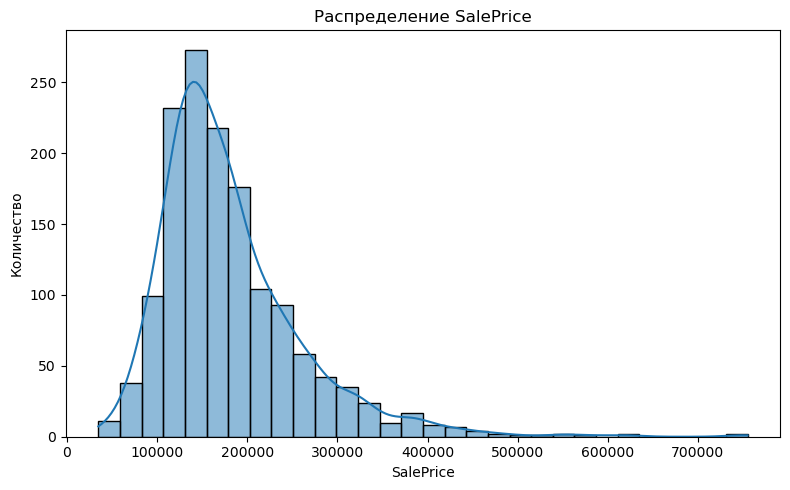

In [8]:
plt.figure(figsize = (8, 5))
sns.histplot(data['SalePrice'], bins = 30, kde = True)
plt.title('Распределение SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

- Наблюдается небольшая скошеность влево

### Пустые значения

In [9]:
null_stats = pd.DataFrame(data.isnull().sum(), columns=['Кол-во'])
null_stats.loc[:,'%'] = np.round(null_stats.loc[:,'Кол-во'] / data.shape[0] * 100, 2)
null_stats.loc[null_stats.loc[:,'Кол-во']>0,:].sort_values(by='Кол-во', ascending=False)

,Кол-во,%
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
MasVnrType,872,59.73
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageType,81,5.55
GarageYrBlt,81,5.55
GarageFinish,81,5.55


**Было принято решение удалить переменные в которых пустых значений больше 60%:**
- `PoolQC`: 99.52%.
- `MiscFeature`: 96.30%.
- `Alley`: 93.77%.
- `Fence`: 80.75%.
- `MasVnrType`: 59.73%.
  
**В данных переменных нужно обратить внимание на выбор метода замены пустых значений:**
- `FireplaceQu`: 47.26%.
- `LotFrontage`: 17.74%.

**Т.к. в данных переменных низкий процент пустых значений, можно просто заменить на медиану:**
- Признаки гаража (`GarageType` , `GarageYrBlt` , `GarageFinish` , `GarageQual` , `GarageCond`):
   5.55% каждый.
- Признаки подвала (`BsmtExposure` , `BsmtFinType1/2` , `BsmtQual` , `BsmtCond`):
   примерно 2.5–2.6%.
- `MasVnrArea` : 0.55%.
- `Electrical` : 0.07%.

# Числовые

In [10]:
data[numerical_features_data].isnull().mean().sort_values(ascending=False)

LotFrontage      0.177397
GarageYrBlt      0.055479
MasVnrArea       0.005479
Id               0.000000
MSSubClass       0.000000
OverallQual      0.000000
LotArea          0.000000
YearBuilt        0.000000
OverallCond      0.000000
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
YearRemodAdd     0.000000
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
BsmtFullBath     0.000000
BsmtHalfBath     0.000000
FullBath         0.000000
TotalBsmtSF      0.000000
HalfBath         0.000000
BedroomAbvGr     0.000000
TotRmsAbvGrd     0.000000
KitchenAbvGr     0.000000
Fireplaces       0.000000
GarageCars       0.000000
GarageArea       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
EnclosedPorch    0.000000
3SsnPorch        0.000000
ScreenPorch      0.000000
PoolArea         0.000000
MiscVal          0.000000
MoSold           0.000000
YrSold           0.000000
dtype: float64

- Так как процент пустых значений маленький, то пустые значения можно просто заменить на медианую.

# Категориальные

In [11]:
data[categorical_features_data].isnull().mean().sort_values(ascending=False)

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
MasVnrType       0.597260
FireplaceQu      0.472603
GarageFinish     0.055479
GarageQual       0.055479
GarageType       0.055479
GarageCond       0.055479
BsmtFinType2     0.026027
BsmtExposure     0.026027
BsmtFinType1     0.025342
BsmtQual         0.025342
BsmtCond         0.025342
Electrical       0.000685
Condition1       0.000000
Condition2       0.000000
LotShape         0.000000
Street           0.000000
MSZoning         0.000000
Neighborhood     0.000000
LandSlope        0.000000
LotConfig        0.000000
Utilities        0.000000
LandContour      0.000000
RoofStyle        0.000000
Heating          0.000000
ExterCond        0.000000
Foundation       0.000000
HouseStyle       0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
ExterQual        0.000000
BldgType         0.000000
HeatingQC        0.000000
CentralAir       0.000000
KitchenQual 

<h3><b>FireplaceQu — Качество камина</b></h3>
<p>Оценивает визуальное и физическое качество камина.</p>
<ul>
  <li><b>Ex</b> — Превосходное</li>
  <li><b>Gd</b> — Хорошее</li>
  <li><b>TA</b> — Среднее</li>
  <li><b>Fa</b> — Удовлетворительное</li>
  <li><b>Po</b> — Плохое</li>
  <li><b>NA</b> — Нет камина</li>
</ul>

<h3><b>GarageFinish — Отделка внутренней части гаража</b></h3>
<p>Как отделан интерьер гаража.</p>
<ul>
  <li><b>Fin</b> — Отделан</li>
  <li><b>RFn</b> — Грубая отделка</li>
  <li><b>Unf</b> — Без отделки</li>
  <li><b>NA</b> — Нет гаража</li>
</ul>

<h3><b>GarageQual — Качество гаража</b></h3>
<p>Оценивает конструктивное качество гаража.</p>
<ul>
  <li><b>Ex</b> — Превосходное</li>
  <li><b>Gd</b> — Хорошее</li>
  <li><b>TA</b> — Среднее</li>
  <li><b>Fa</b> — Удовлетворительное</li>
  <li><b>Po</b> — Плохое</li>
  <li><b>NA</b> — Нет гаража</li>
</ul>

<h3><b>GarageType — Тип гаража</b></h3>
<p>Расположение или вид гаража.</p>
<ul>
  <li><b>2Types</b> — Два типа гаража</li>
  <li><b>Attchd</b> — Присоединён к дому</li>
  <li><b>Basment</b> — Встроен в подвал</li>
  <li><b>BuiltIn</b> — Встроен в здание</li>
  <li><b>CarPort</b> — Навес</li>
  <li><b>Detchd</b> — Отдельностоящий</li>
  <li><b>NA</b> — Нет гаража</li>
</ul>

<h3><b>GarageCond — Состояние гаража</b></h3>
<p>Физическое состояние гаража.</p>
<ul>
  <li><b>Ex</b>, <b>Gd</b>, <b>TA</b>, <b>Fa</b>, <b>Po</b>, <b>NA</b> — как и в GarageQual</li>
</ul>

<h3><b>BsmtFinType2 — Тип отделки второй части подвала</b></h3>
<p>Дополнительная (вторая) часть подвала.</p>
<ul>
  <li><b>GLQ</b> — Жилое помещение высокого качества</li>
  <li><b>ALQ</b> — Жилое помещение среднего качества</li>
  <li><b>BLQ</b> — Жилое помещение ниже среднего</li>
  <li><b>Rec</b> — Комната отдыха</li>
  <li><b>LwQ</b> — Отделка низкого качества</li>
  <li><b>Unf</b> — Не отделан</li>
  <li><b>NA</b> — Нет подвала</li>
</ul>

<h3><b>BsmtExposure — Наличие окон или выхода из подвала наружу</b></h3>
<ul>
  <li><b>Gd</b> — Хорошее освещение/выход</li>
  <li><b>Av</b> — Среднее освещение</li>
  <li><b>Mn</b> — Минимальное освещение</li>
  <li><b>No</b> — Нет окон</li>
  <li><b>NA</b> — Нет подвала</li>
</ul>

<h3><b>BsmtFinType1 — Тип отделки основной части подвала</b></h3>
<p>Аналогично BsmtFinType2, но для основной части подвала.</p>

<h3><b>BsmtQual — Качество подвала</b></h3>
<p>Общая оценка качества подвала.</p>
<ul>
  <li><b>Ex</b>, <b>Gd</b>, <b>TA</b>, <b>Fa</b>, <b>Po</b>, <b>NA</b> — те же уровни, что и в других признаках качества</li>
</ul>

<h3><b>BsmtCond — Состояние подвала</b></h3>
<p>Физическое состояние конструкции подвала.</p>
<ul>
  <li><b>Ex</b>, <b>Gd</b>, <b>TA</b>, <b>Fa</b>, <b>Po</b>, <b>NA</b> — аналогично BsmtQual</li>
</ul>

<h3><b>Electrical — Тип электропроводки</b></h3>
<ul>
  <li><b>SBrkr</b> — Автоматические выключатели (стандарт)</li>
  <li><b>FuseA</b> — Пробки более 60 ампер</li>
  <li><b>FuseF</b> — Пробки 60 ампер</li>
  <li><b>FuseP</b> — Пробки менее 60 ампер</li>
  <li><b>Mix</b> — Комбинация типов</li>
  <li><b>NA</b> — Нет данных</li>
</ul>

**Вывод:**

- По подробным описаниям категорий можно сказать, что пустые значения можно заменить на значение `None`.
  
**Это позволит нам не применять замену пустых значений, а в дальнейшем применить кодирование переменных**

In [12]:
data[categorical_features_data] = data[categorical_features_data].fillna('None')

In [13]:
data[categorical_features_data].isnull().mean()

MSZoning         0.0
Street           0.0
Alley            0.0
LotShape         0.0
LandContour      0.0
Utilities        0.0
LotConfig        0.0
LandSlope        0.0
Neighborhood     0.0
Condition1       0.0
Condition2       0.0
BldgType         0.0
HouseStyle       0.0
RoofStyle        0.0
RoofMatl         0.0
Exterior1st      0.0
Exterior2nd      0.0
MasVnrType       0.0
ExterQual        0.0
ExterCond        0.0
Foundation       0.0
BsmtQual         0.0
BsmtCond         0.0
BsmtExposure     0.0
BsmtFinType1     0.0
BsmtFinType2     0.0
Heating          0.0
HeatingQC        0.0
CentralAir       0.0
Electrical       0.0
KitchenQual      0.0
Functional       0.0
FireplaceQu      0.0
GarageType       0.0
GarageFinish     0.0
GarageQual       0.0
GarageCond       0.0
PavedDrive       0.0
PoolQC           0.0
Fence            0.0
MiscFeature      0.0
SaleType         0.0
SaleCondition    0.0
dtype: float64

# Распределение и Аутлаеры

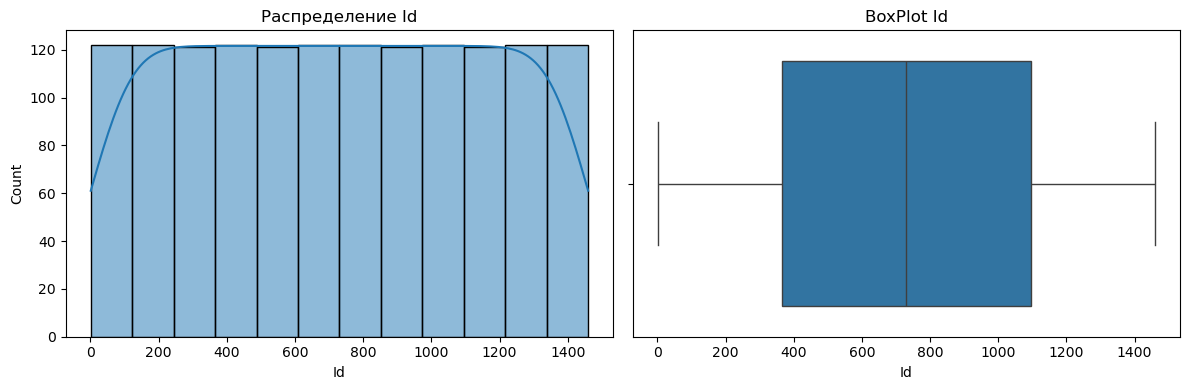

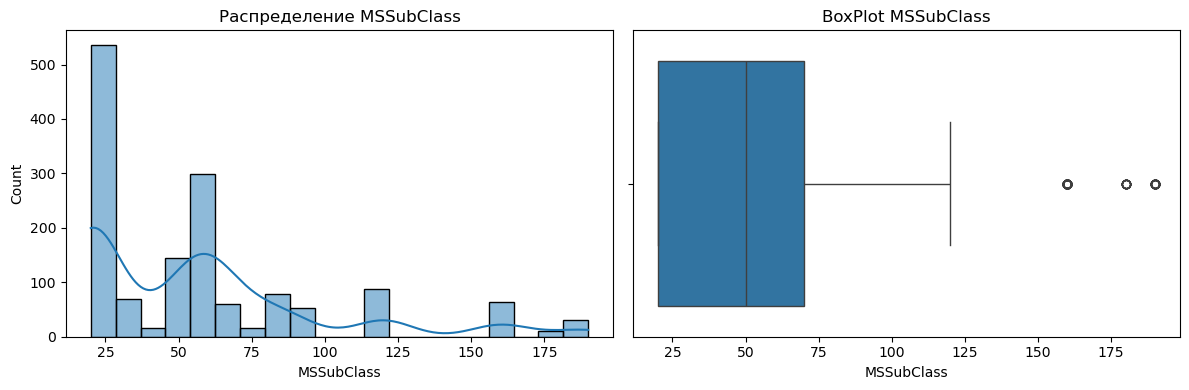

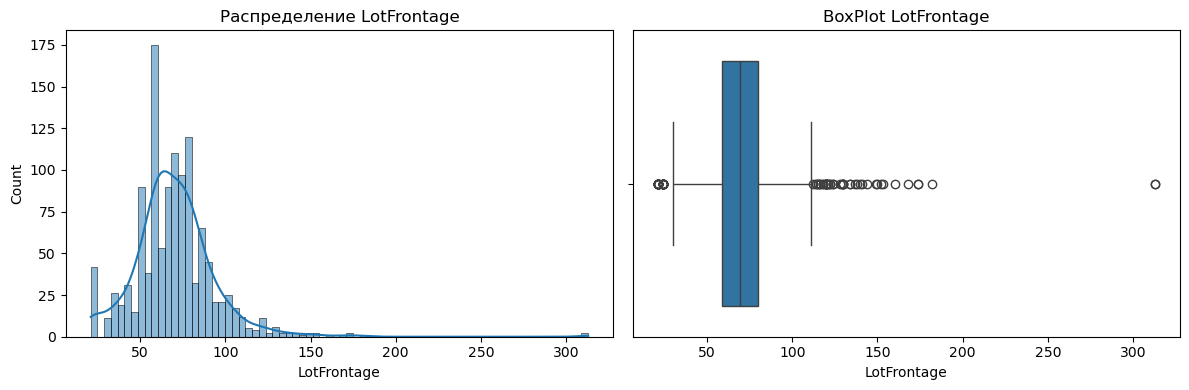

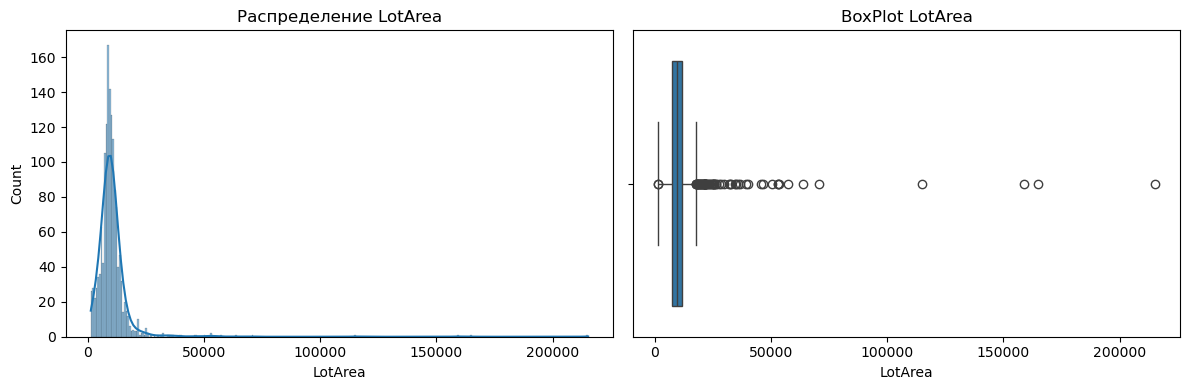

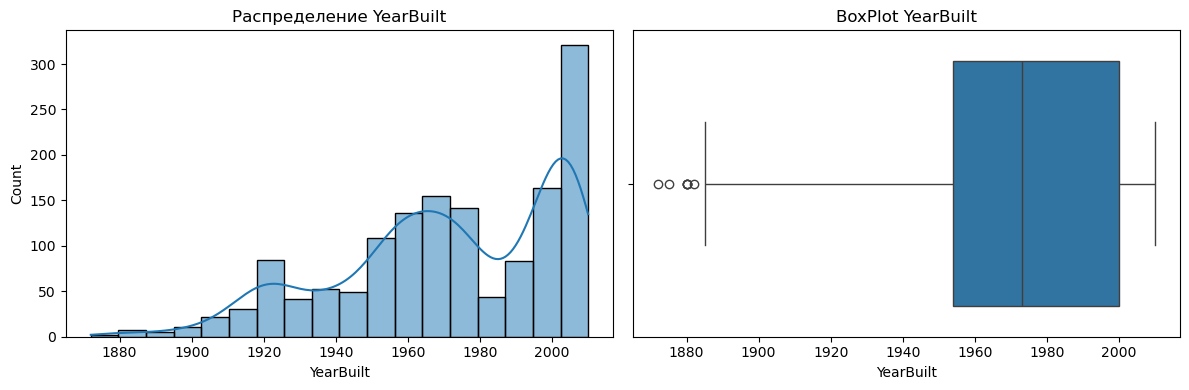

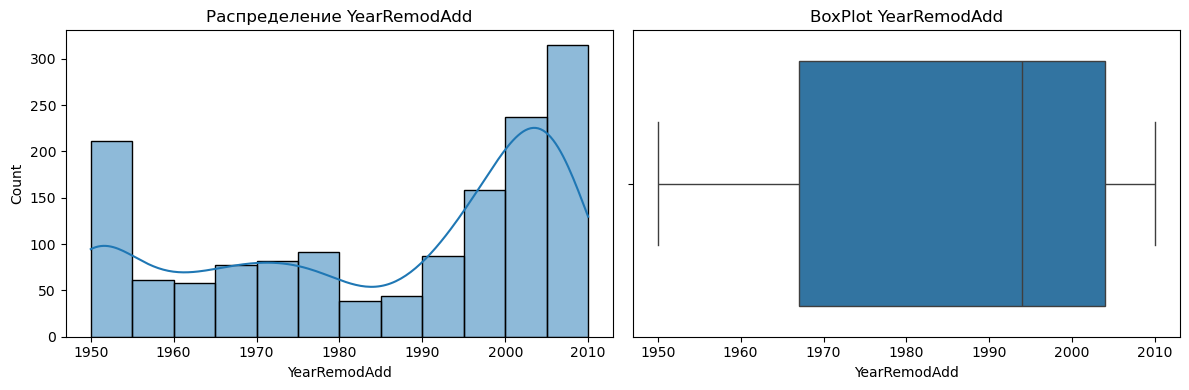

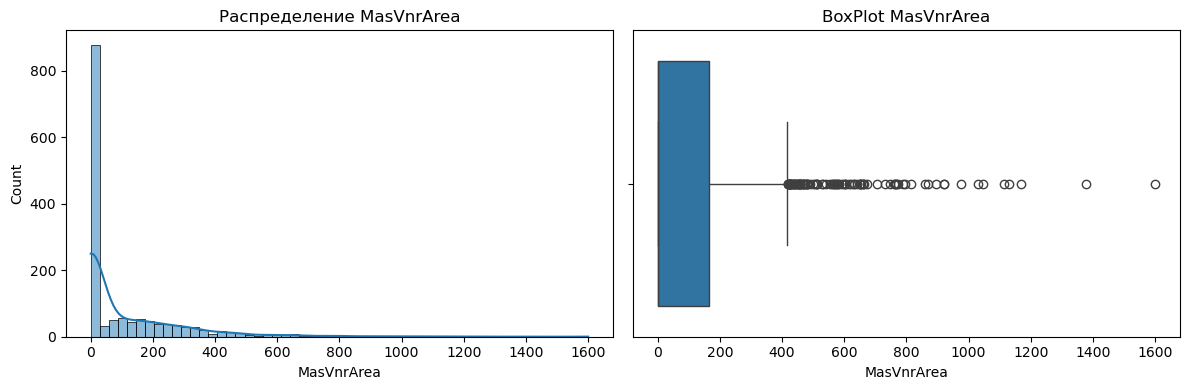

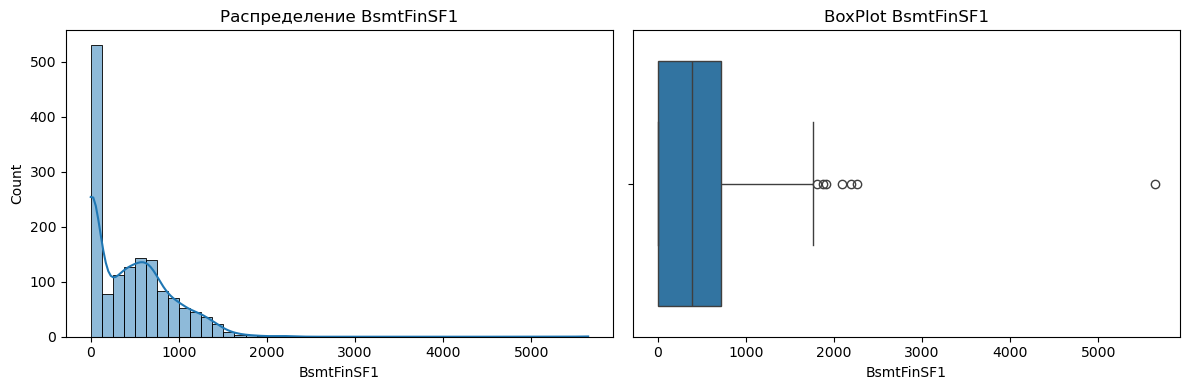

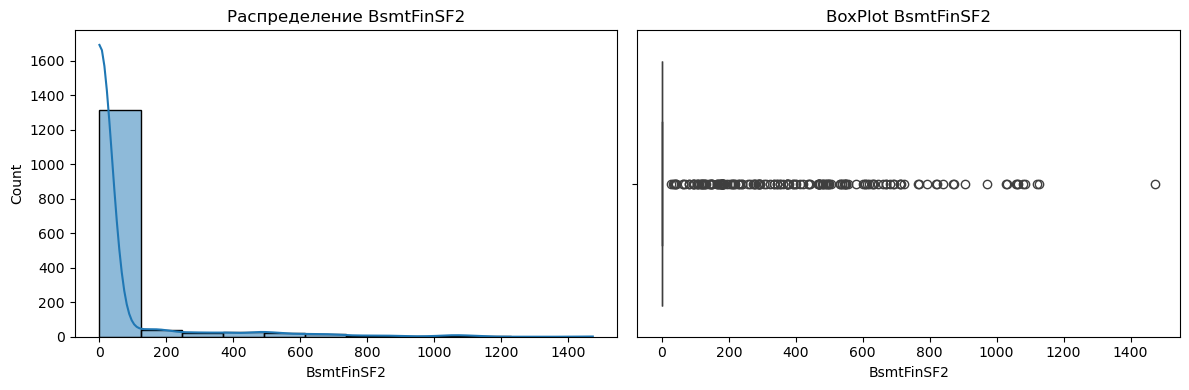

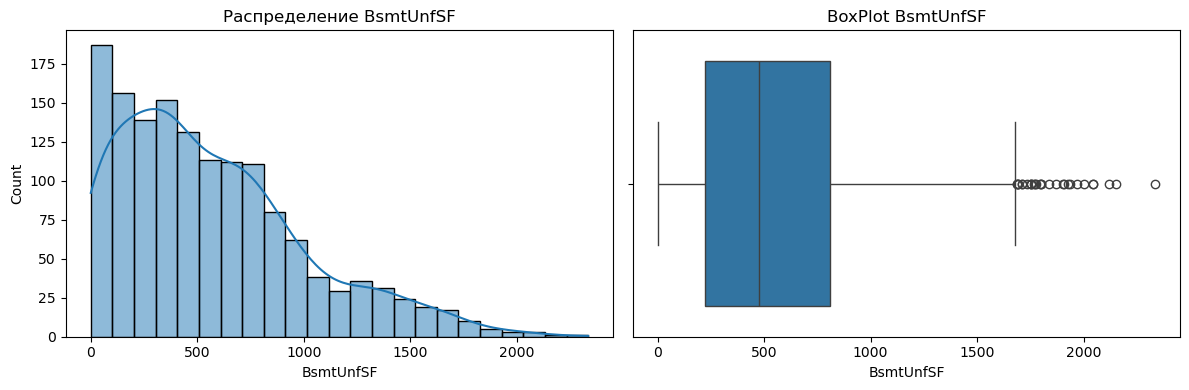

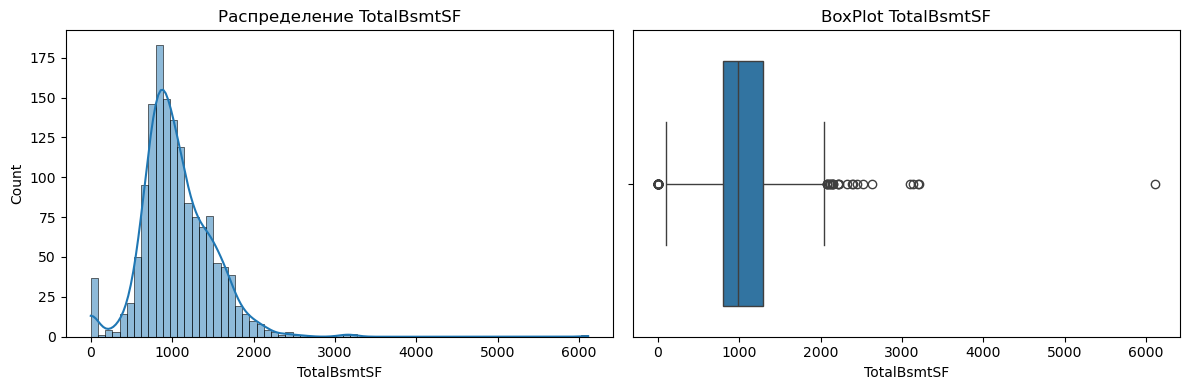

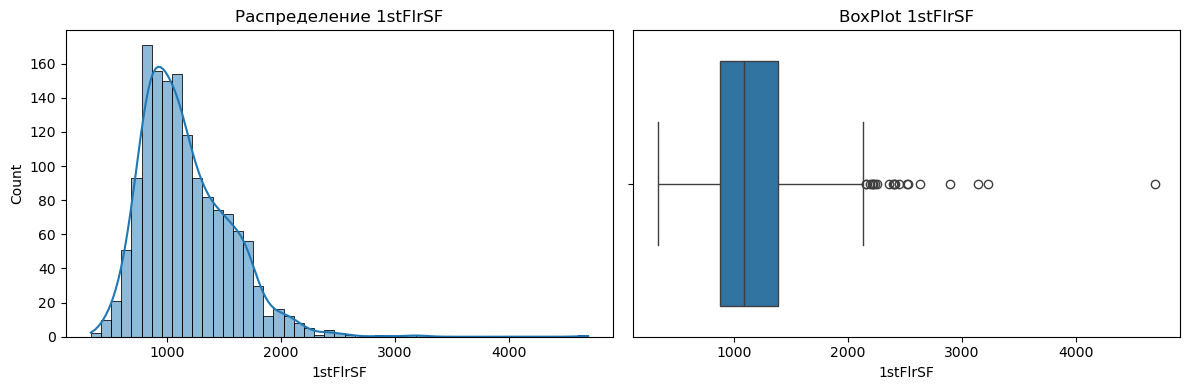

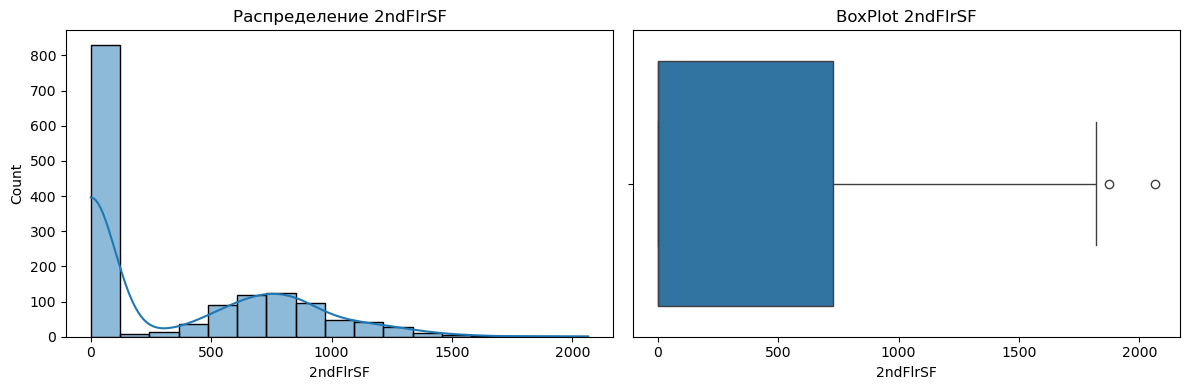

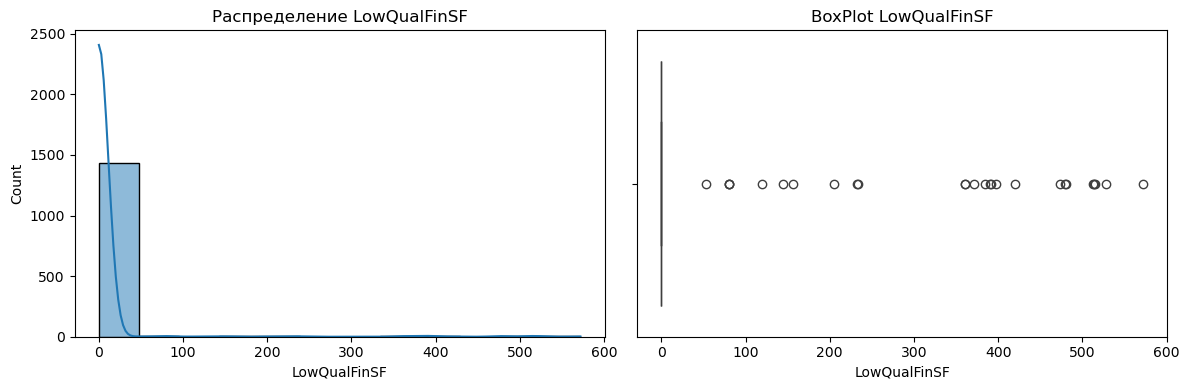

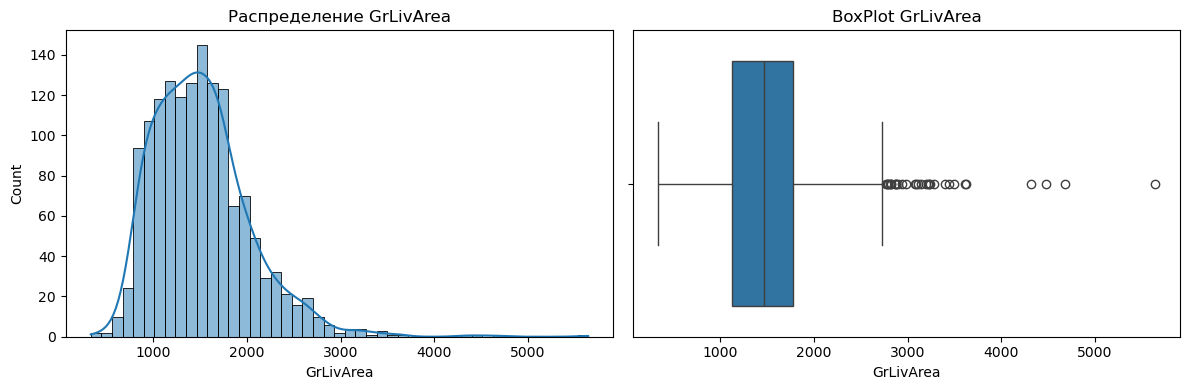

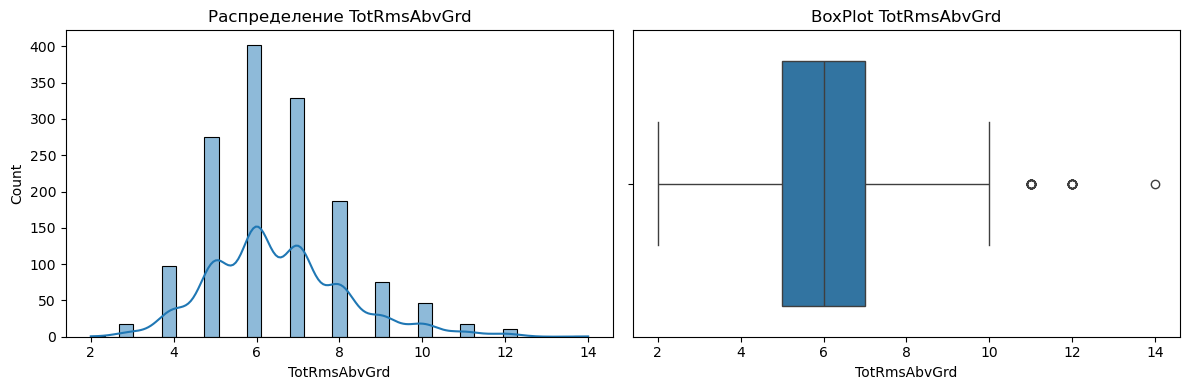

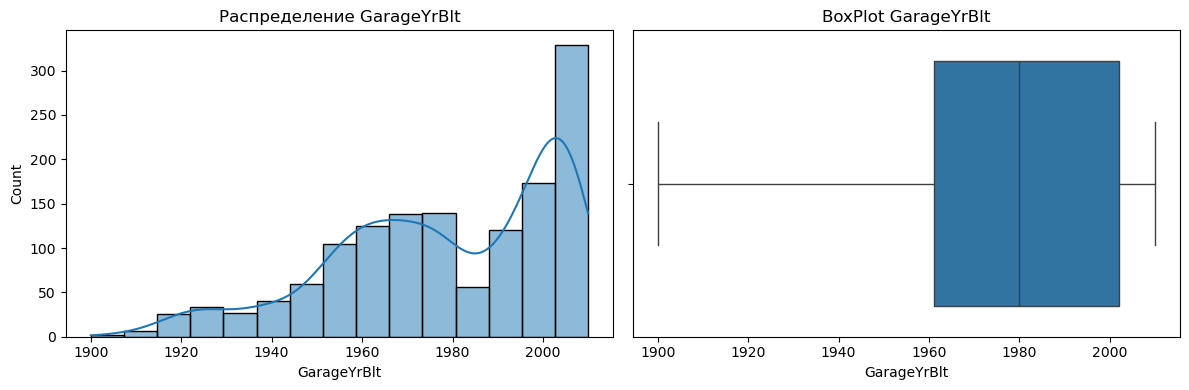

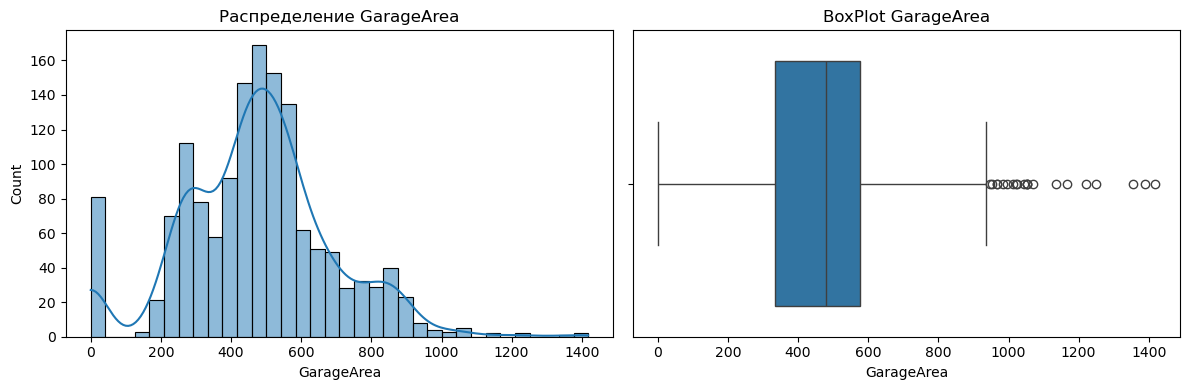

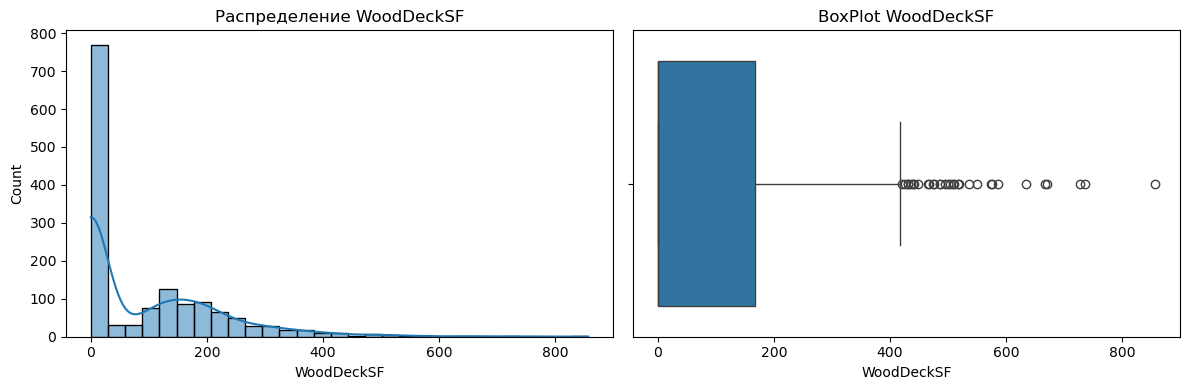

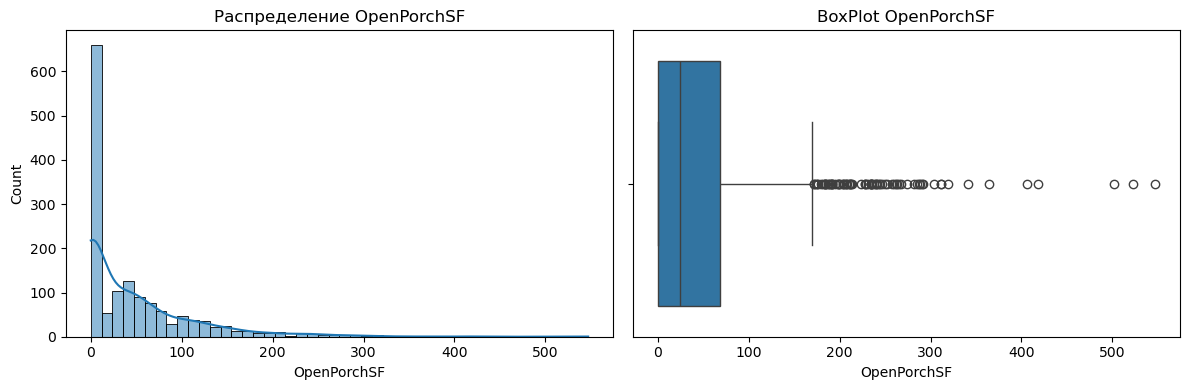

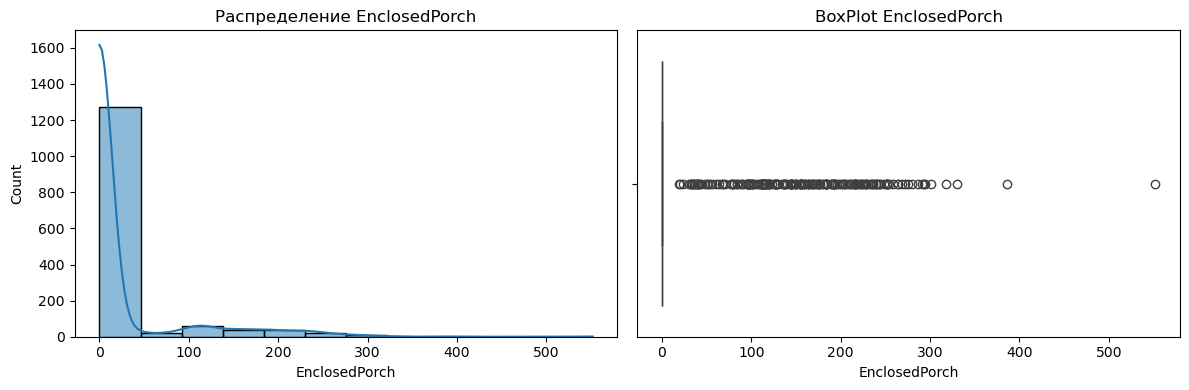

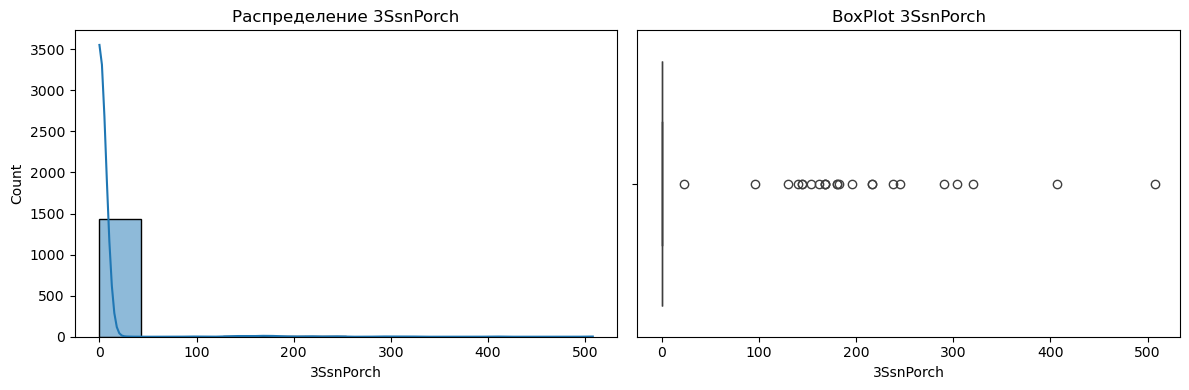

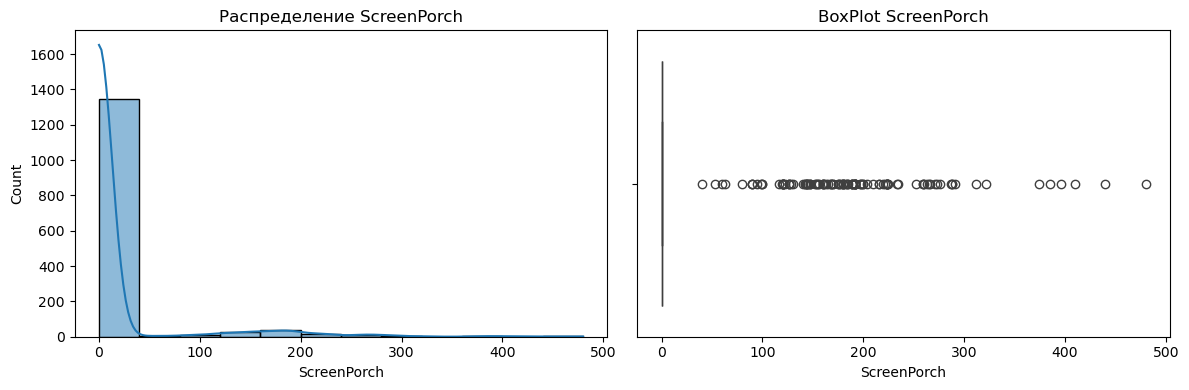

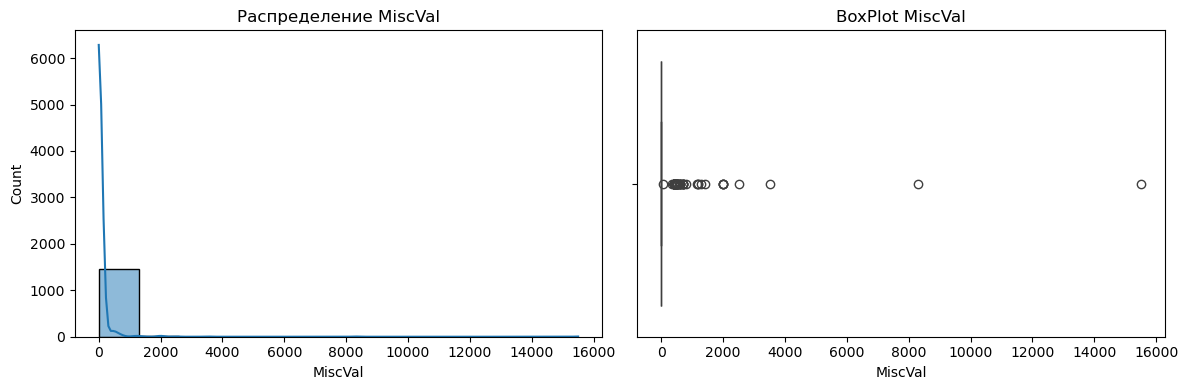

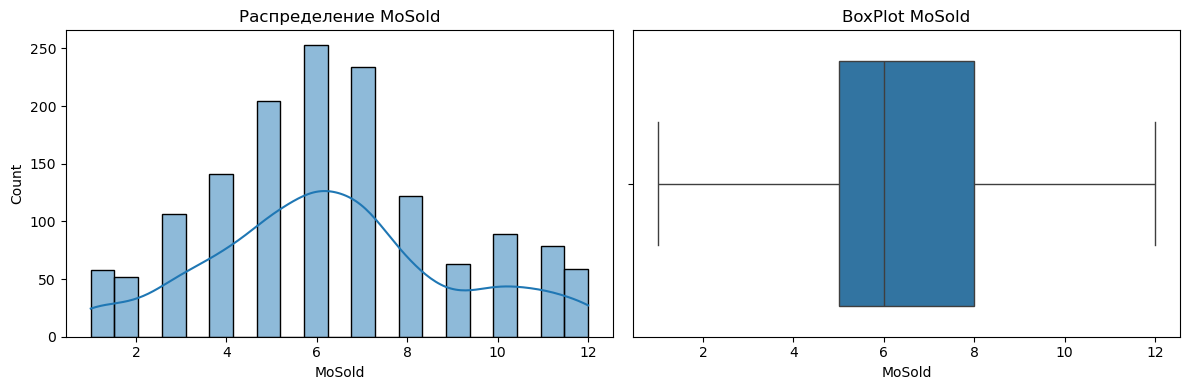

In [14]:
for var in continous_features_data:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(data[var], kde = True, ax = axs[0])
    axs[0].set_title(f'Распределение {var}')

    sns.boxplot(x = data[var], ax = axs[1])
    axs[1].set_title(f'BoxPlot {var}')

    plt.tight_layout()
    plt.show()

- В данном наблюдении мы наблюдаем скошенное распределение почти у всех переменных.

# Корреляционная матрица

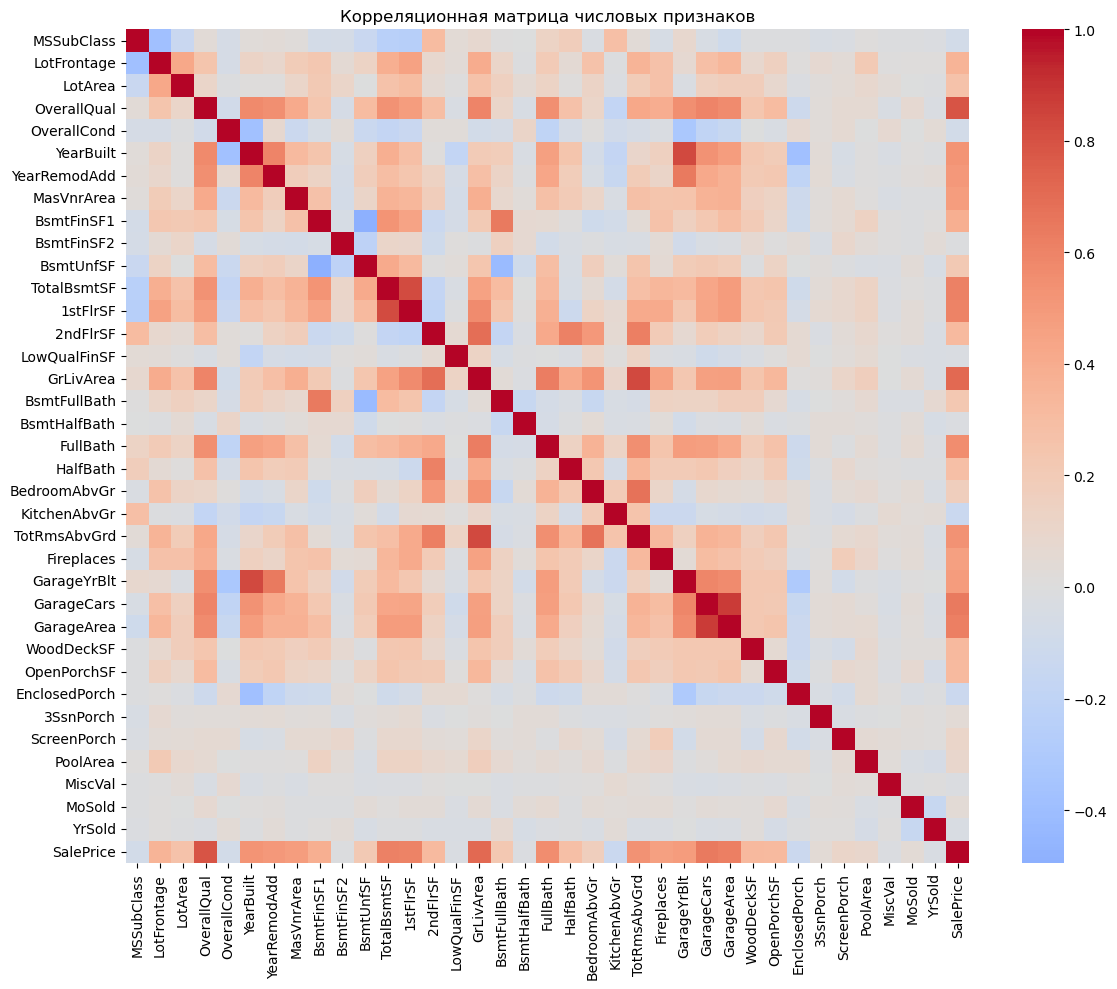

In [15]:
num_cols = data.select_dtypes(include='number').drop(columns=['Id'])
corr = num_cols.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, fmt=".2f", annot=False)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()

**Самая сильная положительная корреляция с SalePrice прослеживается у:**

`OverallQual` (≈0.79) — качество материала и отделки,

`GrLivArea` (≈0.71) — жилая площадь,

`GarageCars` и `GarageArea` (≈0.64).

Эти признаки — очевидные первичные кандидаты для модели.

In [16]:
corr_with_target = data.corr(numeric_only = True)['SalePrice'].sort_values(ascending = False)
corr_with_target

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

# Сброс ненужных переменных

In [17]:
data = data.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], axis = 1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Разделение на тренировочный и тестовый сет

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['SalePrice'], axis = 1),
    data['SalePrice'],
    test_size = 0.3,
    random_state = 0
)

X_train.shape, X_test.shape

((1022, 74), (438, 74))

# Замена пустых значений

In [21]:
imputer = MeanMedianImputer(imputation_method = 'median', variables = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

In [22]:
X_train_imp.isnull().mean()

MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
                ... 
MiscVal          0.0
MoSold           0.0
YrSold           0.0
SaleType         0.0
SaleCondition    0.0
Length: 74, dtype: float64

In [23]:
X_test_imp.isnull().mean()

MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
                ... 
MiscVal          0.0
MoSold           0.0
YrSold           0.0
SaleType         0.0
SaleCondition    0.0
Length: 74, dtype: float64

# Кодирование категориальных переменных

- Для кодирования будем применять OHE, так как данный метод хоть и расширяет `Feature-space` , но является универсальным методом. 

In [32]:
ohe = OneHotEncoder(drop_last = True)
X_train_enc = ohe.fit_transform(X_train_imp)
X_test_enc = ohe.transform(X_test_imp)

In [33]:
X_train_enc.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLD,SaleType_COD,SaleType_Oth,SaleType_ConLI,SaleType_Con,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand
64,60,69.0,9375,7,5,1997,1998,573.0,739,0,...,0,0,0,0,0,1,0,0,0,0
682,120,69.0,2887,6,5,1996,1997,0.0,1003,0,...,0,0,0,0,0,1,0,0,0,0
960,20,50.0,7207,5,7,1958,2008,0.0,696,0,...,0,0,0,0,0,1,0,0,0,0
1384,50,60.0,9060,6,5,1939,1950,0.0,204,0,...,0,0,0,0,0,1,0,0,0,0
1100,30,60.0,8400,2,5,1920,1950,0.0,290,0,...,0,0,0,0,0,1,0,0,0,0


# Масштабирование

## Стандартизация

In [48]:
scaler_standard = StandardScaler()

scaler_standard.fit(X_train_enc)

X_train_standard = pd.DataFrame(
    scaler_standard.transform(X_train_enc),
    columns = X_train_enc.columns
)

In [55]:
X_train_standard.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLD,SaleType_COD,SaleType_Oth,SaleType_ConLI,SaleType_Con,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand
count,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,...,1.022000e+03,1.022000e+03,1.022000e+03,1022.000000,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03
mean,9.038215e-17,8.082250e-17,-4.953637e-17,-3.024326e-16,-3.476236e-17,1.360947e-15,-3.199007e-15,-2.954801e-17,5.996508e-17,-1.738118e-18,...,3.476236e-18,6.952473e-18,2.780989e-17,0.000000,-2.085742e-17,1.147158e-16,1.911930e-17,2.694083e-17,3.476236e-18,-2.259554e-17
std,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,...,1.000490e+00,1.000490e+00,1.000490e+00,1.000490,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00
min,-8.688797e-01,-2.331199e+00,-9.010062e-01,-3.742388e+00,-4.080946e+00,-3.273185e+00,-1.692964e+00,-5.686169e-01,-1.029109e+00,-2.985070e-01,...,-7.684733e-02,-1.615686e-01,-4.428074e-02,-0.062684,-3.129588e-02,-2.200000e+00,-8.304548e-02,-2.752989e-01,-2.953541e-01,-5.425922e-02
25%,-8.688797e-01,-4.583646e-01,-2.746841e-01,-7.951944e-01,-5.032262e-01,-5.604265e-01,-8.635251e-01,-5.686169e-01,-1.029109e+00,-2.985070e-01,...,-7.684733e-02,-1.615686e-01,-4.428074e-02,-0.062684,-3.129588e-02,4.545455e-01,-8.304548e-02,-2.752989e-01,-2.953541e-01,-5.425922e-02
50%,-1.569649e-01,-2.617212e-02,-1.003250e-01,-5.839596e-02,-5.032262e-01,3.505701e-02,4.050280e-01,-5.686169e-01,-1.308402e-01,-2.985070e-01,...,-7.684733e-02,-1.615686e-01,-4.428074e-02,-0.062684,-3.129588e-02,4.545455e-01,-8.304548e-02,-2.752989e-01,-2.953541e-01,-5.425922e-02
75%,3.176449e-01,4.540417e-01,9.994257e-02,6.784025e-01,3.912037e-01,9.613648e-01,8.929331e-01,3.694492e-01,6.173293e-01,-2.985070e-01,...,-7.684733e-02,-1.615686e-01,-4.428074e-02,-0.062684,-3.129588e-02,4.545455e-01,-8.304548e-02,-2.752989e-01,-2.953541e-01,-5.425922e-02
max,3.165304e+00,1.169105e+01,1.989814e+01,2.888798e+00,3.074493e+00,1.292189e+00,1.234467e+00,8.260240e+00,4.230185e+00,6.795650e+00,...,1.301281e+01,6.189321e+00,2.258318e+01,15.953056,3.195309e+01,4.545455e-01,1.204159e+01,3.632416e+00,3.385766e+00,1.843005e+01


## Нормализация

In [51]:
scaler_norm = Normalizer()

scaler_norm.fit(X_train_enc)

X_train_norm = pd.DataFrame(
    scaler_norm.transform(X_train_enc),
    columns = X_train_enc.columns
)

In [52]:
X_train_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1022.0,6.384545e-03,0.007276,0.000093,0.001962,0.004384,0.006595,0.040821
LotFrontage,1022.0,6.511655e-03,0.001742,0.000419,0.005549,0.006681,0.007331,0.014713
LotArea,1022.0,8.633732e-01,0.114066,0.287170,0.857781,0.894351,0.922150,0.999666
OverallQual,1022.0,5.981760e-04,0.000229,0.000030,0.000465,0.000563,0.000684,0.001516
OverallCond,1022.0,5.544698e-04,0.000220,0.000023,0.000409,0.000508,0.000664,0.001582
...,...,...,...,...,...,...,...,...
SaleCondition_Normal,1022.0,8.338371e-05,0.000050,0.000000,0.000066,0.000089,0.000107,0.000227
SaleCondition_Alloca,1022.0,6.551883e-07,0.000008,0.000000,0.000000,0.000000,0.000000,0.000120
SaleCondition_Abnorml,1022.0,7.439902e-06,0.000029,0.000000,0.000000,0.000000,0.000000,0.000226
SaleCondition_Partial,1022.0,7.119901e-06,0.000026,0.000000,0.000000,0.000000,0.000000,0.000178


## MaxAbsolute

In [53]:
scaler_maxabs = MaxAbsScaler()
scaler_maxabs.fit_transform(X_train_enc)

X_train_maxabs = pd.DataFrame(
    scaler_maxabs.transform(X_train_enc),
    columns = X_train_enc.columns
)

In [54]:
X_train_maxabs.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLD,SaleType_COD,SaleType_Oth,SaleType_ConLI,SaleType_Con,SaleCondition_Normal,SaleCondition_Alloca,SaleCondition_Abnorml,SaleCondition_Partial,SaleCondition_AdjLand
count,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,...,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000,1022.000000
mean,0.297971,0.222189,0.049097,0.607926,0.618069,0.980567,0.987412,0.064404,0.195674,0.042078,...,0.005871,0.025440,0.001957,0.003914,0.000978,0.828767,0.006849,0.070450,0.080235,0.002935
std,0.221897,0.066563,0.047812,0.135789,0.124286,0.015046,0.010202,0.113320,0.190233,0.141030,...,0.076434,0.157535,0.044216,0.062469,0.031281,0.376897,0.082517,0.256029,0.271789,0.054126
min,0.105263,0.067093,0.006040,0.100000,0.111111,0.931343,0.970149,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.105263,0.191693,0.035971,0.500000,0.555556,0.972139,0.978607,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.263158,0.220447,0.044303,0.600000,0.555556,0.981095,0.991542,0.000000,0.170796,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.368421,0.252396,0.053873,0.700000,0.666667,0.995025,0.996517,0.106250,0.313053,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Мы решили работать с MaxAbsolute, так как среднее значение почти у всех переменных приближено к нулю.
- А диапазон значений имеет интервалы от 0 до 1.

# Отбор переменных

## Констаные и Квази-константные переменные

In [57]:
const_quasi = DropConstantFeatures(tol = 0.998, variables = None, missing_values = 'raise')
const_quasi.fit(X_train_maxabs)
const_quasi.features_to_drop_

['Utilities_AllPub',
 'Condition2_PosN',
 'Condition2_Artery',
 'RoofStyle_Shed',
 'RoofMatl_Metal',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_ImStucc',
 'Exterior1st_CBlock',
 'Exterior2nd_AsphShn',
 'Exterior2nd_CBlock',
 'ExterCond_Ex',
 'Heating_OthW',
 'Heating_Wall',
 'Electrical_FuseP',
 'Electrical_None',
 'GarageQual_Ex',
 'GarageCond_Ex',
 'SaleType_Oth',
 'SaleType_Con']

In [58]:
X_train_const = X_train_maxabs.drop(labels = const_quasi.features_to_drop_, axis = 1)
X_train_const.shape

(1022, 218)

## Дублируемые переменные

In [61]:
dublicated = DropDuplicateFeatures(variables = None, missing_values = 'raise')
dublicated.fit(X_train_const)
dublicated.features_to_drop_

{'BsmtCond_None',
 'BsmtExposure_None',
 'BsmtFinType1_None',
 'GarageCond_None',
 'GarageFinish_None',
 'GarageQual_None'}

In [62]:
X_train_dublicated = X_train_const.drop(labels = dublicated.features_to_drop_, axis = 1)
X_train_dublicated.shape

(1022, 212)

## Коррелируемые переменные

In [64]:
correlated = SmartCorrelatedSelection(
    variables = None, 
    method = 'pearson',
    threshold = 0.8,
    missing_values = 'raise',
    selection_method = 'variance',
    estimator = None,
    scoring = 'roc_auc',
    cv = 5
)

correlated.fit(X_train_dublicated, y_train)
correlated.features_to_drop_

['KitchenQual_Gd',
 'Fireplaces',
 'ExterQual_Gd',
 'LotShape_IR1',
 'Exterior2nd_VinylSd',
 '2ndFlrSF',
 'RoofStyle_Hip',
 'MSZoning_RM',
 'MSSubClass',
 'Exterior2nd_HdBoard',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_MetalSd',
 'ExterCond_Gd',
 'Electrical_FuseA',
 'SaleType_New',
 'LandSlope_Mod',
 'MSZoning_FV',
 'Exterior2nd_CmentBd',
 'GarageArea',
 'BsmtQual_None',
 'Foundation_Slab',
 'Exterior1st_AsbShng',
 'GrLivArea',
 'RoofMatl_Tar&Grv']

In [67]:
X_train_filtered = correlated.transform(X_train_dublicated)
X_train_filtered.shape, X_train_maxabs.shape

((1022, 188), (1022, 238))

# Трансформация и Дискретизация таргета

## Логарифмическая трансформация таргета

In [36]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

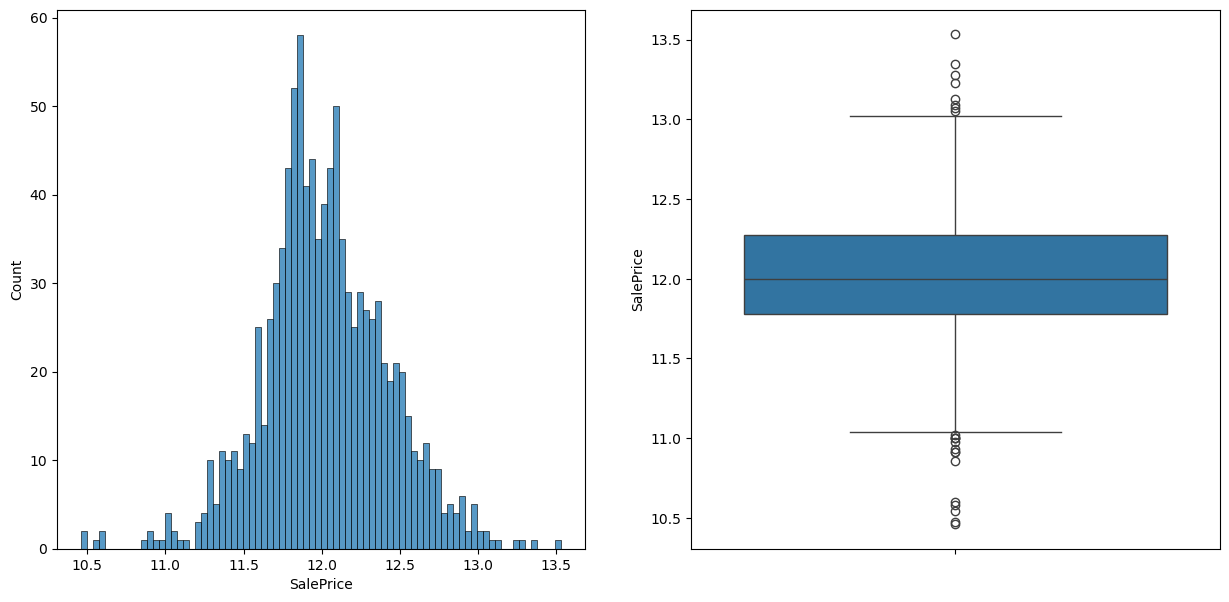

In [45]:
histogram_boxcox(y_train)

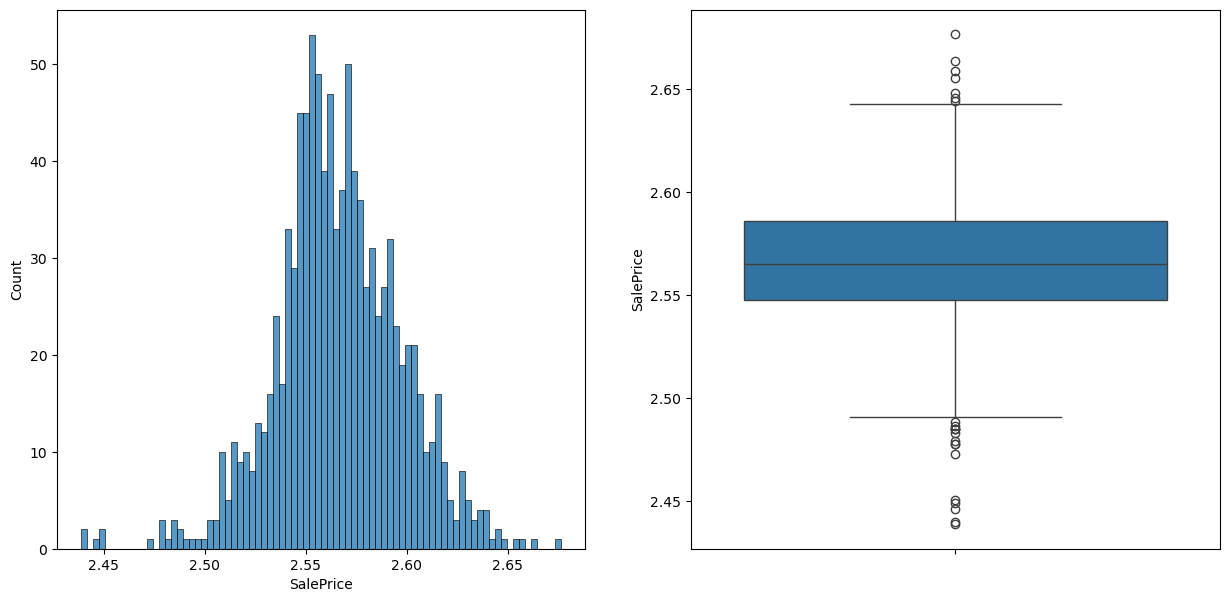

In [46]:
histogram_boxcox(y_train_log)

- На основе анализа, сделали вывод, что логорифмирование можно не применять, т.к. разница не большая.

# SVR

In [72]:
svr_pipe = Pipeline([
    ('imputer', MeanMedianImputer(imputation_method = 'median', variables = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])),
    ('ohe', OneHotEncoder(drop_last=True)),
    ('scaler', MaxAbsScaler()),
    ('const_quasi', DropConstantFeatures(tol = 0.998, variables = None, missing_values = 'raise')),
    ('dublicated', DropDuplicateFeatures(variables = None, missing_values = 'raise')),
    ('corr', SmartCorrelatedSelection(
        variables = None, 
        method = 'pearson',
        threshold = 0.8,
        missing_values = 'raise',
        selection_method = 'variance',
        estimator = None,
        scoring = 'roc_auc',
        cv = 5
    )),
    ('model', SVR())
])

svr_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('ohe', OneHotEncoder(drop_last=True)),
                ('scaler', MaxAbsScaler()),
                ('const_quasi', DropConstantFeatures(tol=0.998)),
                ('dublicated', DropDuplicateFeatures(missing_values='raise')),
                ('corr',
                 SmartCorrelatedSelection(cv=5, missing_values='raise',
                                          selection_method='variance')),
                ('model', SVR())])

In [76]:
y_pred_train = svr_pipe.predict(X_train)
y_pred_test = svr_pipe.predict(X_test)

#Printing of scores,
print('Train set')
print(' MAE: {}'.format(mean_absolute_error(y_train, y_pred_train)))
print(' RMSE: {}'.format(mean_squared_error(y_train, y_pred_train)))
print(' R2: {}'.format(r2_score(y_train, y_pred_train)))
print()
print('Test set')
print(' MAE: {}'.format(mean_absolute_error(y_test, y_pred_test)))
print(' RMSE: {}'.format(mean_squared_error(y_test, y_pred_test)))
print(' R2: {}'.format(r2_score(y_test, y_pred_test)))

Train set
 MAE: 0.06982469265582747
 RMSE: 0.007861714413385325
 R2: 0.9513383193867695

Test set
 MAE: 0.09336126404639246
 RMSE: 0.017908806726286735
 R2: 0.8840923661892629


## DecisionTreeRegressor

In [77]:
dtr_pipe = Pipeline([
    ('imputer', MeanMedianImputer(imputation_method = 'median', variables = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])),
    ('ohe', OneHotEncoder(drop_last=True)),
    ('scaler', MaxAbsScaler()),
    ('const_quasi', DropConstantFeatures(tol = 0.998, variables = None, missing_values = 'raise')),
    ('dublicated', DropDuplicateFeatures(variables = None, missing_values = 'raise')),
    ('corr', SmartCorrelatedSelection(
        variables = None, 
        method = 'pearson',
        threshold = 0.8,
        missing_values = 'raise',
        selection_method = 'variance',
        estimator = None,
        scoring = 'roc_auc',
        cv = 5
    )),
    ('model', DecisionTreeRegressor())
])

dtr_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('ohe', OneHotEncoder(drop_last=True)),
                ('scaler', MaxAbsScaler()),
                ('const_quasi', DropConstantFeatures(tol=0.998)),
                ('dublicated', DropDuplicateFeatures(missing_values='raise')),
                ('corr',
                 SmartCorrelatedSelection(cv=5, missing_values='raise',
                                          selection_method='variance')),
                ('model', DecisionTreeRegressor())])

In [78]:
y_pred_train = dtr_pipe.predict(X_train)
y_pred_test = dtr_pipe.predict(X_test)

#Printing of scores,
print('Train set')
print(' MAE: {}'.format(mean_absolute_error(y_train, y_pred_train)))
print(' RMSE: {}'.format(mean_squared_error(y_train, y_pred_train)))
print(' R2: {}'.format(r2_score(y_train, y_pred_train)))
print()
print('Test set')
print(' MAE: {}'.format(mean_absolute_error(y_test, y_pred_test)))
print(' RMSE: {}'.format(mean_squared_error(y_test, y_pred_test)))
print(' R2: {}'.format(r2_score(y_test, y_pred_test)))

Train set
 MAE: 0.0
 RMSE: 0.0
 R2: 1.0

Test set
 MAE: 0.15849611258108703
 RMSE: 0.04648526856634808
 R2: 0.6991425744366608


## RandomForest

In [79]:
rf_pipe = Pipeline([
    ('imputer', MeanMedianImputer(imputation_method = 'median', variables = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])),
    ('ohe', OneHotEncoder(drop_last=True)),
    ('scaler', MaxAbsScaler()),
    ('const_quasi', DropConstantFeatures(tol = 0.998, variables = None, missing_values = 'raise')),
    ('dublicated', DropDuplicateFeatures(variables = None, missing_values = 'raise')),
    ('corr', SmartCorrelatedSelection(
        variables = None, 
        method = 'pearson',
        threshold = 0.8,
        missing_values = 'raise',
        selection_method = 'variance',
        estimator = None,
        scoring = 'roc_auc',
        cv = 5
    )),
    ('model', RandomForestRegressor())
])

rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('ohe', OneHotEncoder(drop_last=True)),
                ('scaler', MaxAbsScaler()),
                ('const_quasi', DropConstantFeatures(tol=0.998)),
                ('dublicated', DropDuplicateFeatures(missing_values='raise')),
                ('corr',
                 SmartCorrelatedSelection(cv=5, missing_values='raise',
                                          selection_method='variance')),
                ('model', RandomForestRegressor())])

In [80]:
y_pred_train = rf_pipe.predict(X_train)
y_pred_test = rf_pipe.predict(X_test)

#Printing of scores,
print('Train set')
print(' MAE: {}'.format(mean_absolute_error(y_train, y_pred_train)))
print(' RMSE: {}'.format(mean_squared_error(y_train, y_pred_train)))
print(' R2: {}'.format(r2_score(y_train, y_pred_train)))
print()
print('Test set')
print(' MAE: {}'.format(mean_absolute_error(y_test, y_pred_test)))
print(' RMSE: {}'.format(mean_squared_error(y_test, y_pred_test)))
print(' R2: {}'.format(r2_score(y_test, y_pred_test)))

Train set
 MAE: 0.0406119690196269
 RMSE: 0.0034337102811059896
 R2: 0.9787463517202992

Test set
 MAE: 0.09799228424653861
 RMSE: 0.01986604279956122
 R2: 0.8714249335942549


# XGBRegressor

In [82]:
xgb_pipe = Pipeline([
    ('imputer', MeanMedianImputer(imputation_method = 'median', variables = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea'])),
    ('ohe', OneHotEncoder(drop_last=True)),
    ('scaler', MaxAbsScaler()),
    ('const_quasi', DropConstantFeatures(tol = 0.998, variables = None, missing_values = 'raise')),
    ('dublicated', DropDuplicateFeatures(variables = None, missing_values = 'raise')),
    ('corr', SmartCorrelatedSelection(
        variables = None, 
        method = 'pearson',
        threshold = 0.8,
        missing_values = 'raise',
        selection_method = 'variance',
        estimator = None,
        scoring = 'roc_auc',
        cv = 5
    )),
    ('model', XGBRegressor())
])

xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 MeanMedianImputer(variables=['LotFrontage', 'GarageYrBlt',
                                              'MasVnrArea'])),
                ('ohe', OneHotEncoder(drop_last=True)),
                ('scaler', MaxAbsScaler()),
                ('const_quasi', DropConstantFeatures(tol=0.998)),
                ('dublicated', DropDuplicateFeatures(missing_values='raise')),
                ('corr',
                 SmartCorrelatedSelection(cv=5, missing_values='raise',
                                          selection_method...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [83]:
y_pred_train = xgb_pipe.predict(X_train)
y_pred_test = xgb_pipe.predict(X_test)

#Printing of scores,
print('Train set')
print(' MAE: {}'.format(mean_absolute_error(y_train, y_pred_train)))
print(' RMSE: {}'.format(mean_squared_error(y_train, y_pred_train)))
print(' R2: {}'.format(r2_score(y_train, y_pred_train)))
print()
print('Test set')
print(' MAE: {}'.format(mean_absolute_error(y_test, y_pred_test)))
print(' RMSE: {}'.format(mean_squared_error(y_test, y_pred_test)))
print(' R2: {}'.format(r2_score(y_test, y_pred_test)))

Train set
 MAE: 0.003780140574849534
 RMSE: 3.151187085480998e-05
 R2: 0.9998049508651127

Test set
 MAE: 0.1014725317177086
 RMSE: 0.022359609723876833
 R2: 0.8552863127266843
